In [30]:
from sklearn.ensemble import VotingClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# this is stacking! 
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
clf3 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=3)

pipeline1 = Pipeline([
    ('scl', StandardScaler()),
    ('clf1', clf1),
])

pipeline2 = Pipeline([
    ('scl', StandardScaler()),
    ('clf2', clf2),
])

clf_labels = ['Logistic', 'KNN', 'DTree']

for clf, label in zip([pipeline1, pipeline2, clf3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC {} {} '.format(scores.mean(), label))

ROC AUC 0.916666666667 Logistic 
ROC AUC 0.933333333333 KNN 
ROC AUC 0.916666666667 DTree 


In [29]:
mv_clf = VotingClassifier(estimators=[('lr', pipeline1), ('knn', pipeline2), ('dt', clf3)],  weights=[1,1,1], voting='soft')

scores = cross_val_score(estimator=mv_clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print('ROC AUC {} Majority vote'.format(scores.mean()))


ROC AUC 0.966666666667 Majority vote


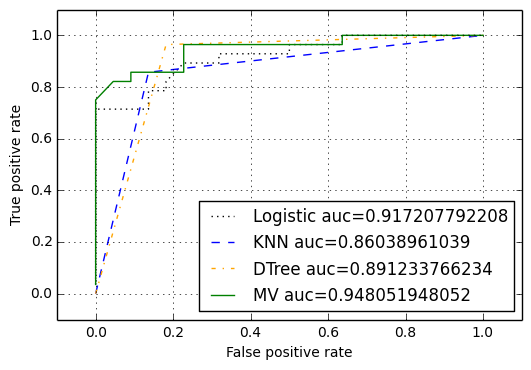

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

colors = ['black', 'blue', 'orange', 'green']
linestyles = [':', '--', '-.', '-']
clf_labels = ['Logistic', 'KNN', 'DTree', 'MV']


for clf, label, clr, ls in zip([pipeline1, pipeline2, clf3, mv_clf], clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='{} auc={}'.format(label, roc_auc))
    
plt.legend(loc='lower right')
plt.grid()
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [40]:
mv_clf.get_params()

{'dt': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=3, splitter='best'),
 'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': 1,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_split': 1e-07,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__presort': False,
 'dt__random_state': 3,
 'dt__splitter': 'best',
 'estimators': [('lr',
   Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf1', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=1, solver='liblinear', tol=0.00